In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets
import torchvision.transforms as trans
from torch import nn
from torch import optim
from IPython.display import clear_output
from torch.utils.data import random_split
from torchsummary import summary
from torchvision.transforms.v2 import RandomHorizontalFlip
from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
transform = trans.Compose([
    trans.Grayscale(num_output_channels=3),
    trans.ToTensor(),
    trans.Normalize((0.5,), (0.5,))
])

In [ ]:
train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [ ]:
test = datasets.FashionMNIST(root='./data', train=False, transform=transform)

In [ ]:
flip = trans.Compose([
    RandomHorizontalFlip(1.0),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5,), (0.5,))
])

In [ ]:
flipped = datasets.FashionMNIST(root='./data', train=True, transform=flip)

In [ ]:
combo = ConcatDataset([train, flipped])

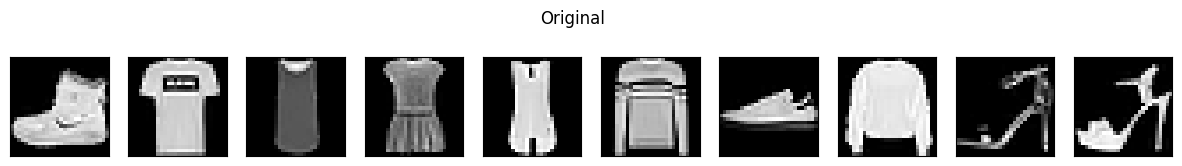

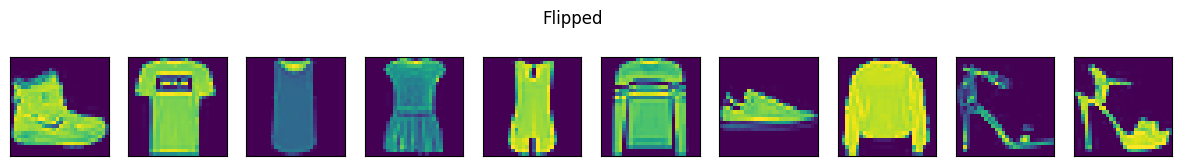

In [ ]:
plt.figure(figsize=(15,2))
plt.suptitle("Original")

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(train[i][0].permute(1, 2, 0) * 0.5 + 0.5)
    plt.xticks([])
    plt.yticks([])


plt.figure(figsize=(15,2))
plt.suptitle("Flipped")

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(flipped[i][0].permute(1, 2, 0) * 0.5 + 0.5)
    plt.xticks([])
    plt.yticks([])


plt.show()

In [ ]:
train_set, valid = random_split(train, (0.95, 0.05))

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(3, 3),
    nn.Conv2d(16, 64, 5),
    nn.ReLU(),
    nn.MaxPool2d(4, 4),
    nn.Flatten(start_dim=-3),
    nn.Linear(in_features=64, out_features=1500),
    nn.BatchNorm1d(1500),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1500, out_features=888),
    nn.BatchNorm1d(888),
    nn.Sigmoid(),
    nn.Linear(in_features=888, out_features=100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=100, out_features=10),
)

In [ ]:
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]           1,216
              ReLU-2           [-1, 16, 24, 24]               0
         MaxPool2d-3             [-1, 16, 8, 8]               0
            Conv2d-4             [-1, 64, 4, 4]          25,664
              ReLU-5             [-1, 64, 4, 4]               0
         MaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                 [-1, 1500]          97,500
       BatchNorm1d-9                 [-1, 1500]           3,000
             ReLU-10                 [-1, 1500]               0
          Dropout-11                 [-1, 1500]               0
           Linear-12                  [-1, 888]       1,332,888
      BatchNorm1d-13                  [-1, 888]           1,776
          Sigmoid-14                  [

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def run(model, dataloader, loss_function, optimizer = None):
  if optimizer == None:
    model.eval()
  else:
    model.train()
  total = 0
  for x, y in dataloader:
    pred = model(x)
    loss = loss_function(pred, y)
    total += loss.item()
    if optimizer != None:
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
  return total / len(dataloader)

In [ ]:
from IPython.display import clear_output

def show_losses(train_loss_hist, test_loss_hist):
    clear_output()

    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

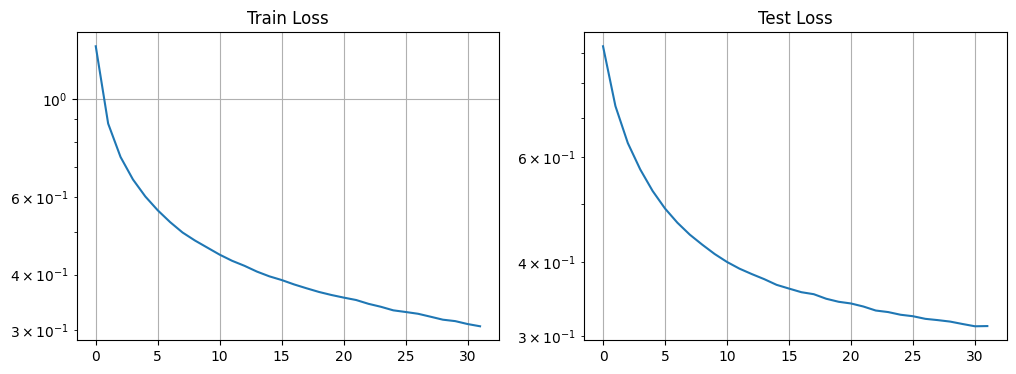

Best Epochs:  30


In [ ]:
Batch = 100
Epochs = 100

train_loader = DataLoader(train_set, batch_size=Batch)
valid_loader = DataLoader(valid, batch_size=Batch)

train_loss_hist = []
test_loss_hist = []
prev_loss = 10 ** 9

for i in range(Epochs):
    train_loss = run(model, train_loader, loss, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run(model, valid_loader, loss)
    test_loss_hist.append(test_loss)
    if i % 1 == 0:
        show_losses(train_loss_hist, test_loss_hist)
    if prev_loss < test_loss:
      print("Best Epochs: ", i - 1)
      break
    else:
      prev_loss = test_loss

In [ ]:
test_loader = DataLoader(test, batch_size=Batch)

In [ ]:
test_loss = run(model, test_loader, loss)
test_loss

0.3354355102777481

In [ ]:
def accuracy(model, dataloader, loss_function, optimizer=None):
    if optimizer == None:
        model.eval()
    else:
        model.train()

    cnt = 0
    all = 0

    for X, y in dataloader:
        pred = model(X)
        for i in range(len(y)):
          x1 = -10 ** 9
          num = -1
          for j in range(len(pred[i])):
            if pred[i][j] > x1:
              x1 = pred[i][j]
              num = j
          y1 = y[i]
          if num == y1:
            cnt+=1
          all+=1

    accuracy = cnt / all
    return accuracy

In [ ]:
acc = accuracy(model, test_loader, loss)
acc

0.8804

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
def prep_metrics(model, dataloader):
  model.eval()
  true = []
  pred = []

  for x, y in dataloader:
    pred_y = model(x)
    _, predicted = torch.max(pred_y.data, 1)
    true.extend(y.cpu().numpy())
    pred.extend(predicted.cpu().numpy())
  return precision_score(true, pred, average='weighted'), recall_score(true, pred, average='weighted')

In [ ]:
precision, recall = prep_metrics(model, test_loader)

In [ ]:
precision

0.8803938446564278

In [ ]:
recall

0.8804

In [ ]:
(2 * precision * recall) / (precision + recall)

0.880396922317455

ВЫВОД

Модель обучалась гороздо дольше, так как было намного больше данных. Однако, я ожидал, что метрики улучшатся, так как данных больше, но они наоборот ухудшились, скорее всего стоит как-то по-другому подходить к аугментации данных. В следующем задании, не буду использовать эту модель, сейчас она не оптимальна.